# Regression Approach

## Overview

When we're dealing with Regressions we are basically trying to estimate the **Expected Mean Coditional on the regressors** of our target variable.

In [2]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import statsmodels.formula.api as smf  

from sklearn.metrics import root_mean_squared_error as rmse

from plotnine import (ggplot, aes, geom_line,facet_grid, theme_bw, labs)
from plotnine.options import set_option

### Utils

In [3]:
def bias(y_true, y_pred):
    return  np.mean(y_true - y_pred)

In [4]:
TARGET = 'farmgate_milk_price'

## Data Reading

In [5]:
#Reading the data
df = pd.read_csv("../data/tidy_data.csv", parse_dates=[0])

In [6]:
df.head()

,date,milk_production,imports,exports,total_supply,population,per_capita_supply,unemployment,wage_mass,uht_milk_industry,uht_milk_market,farmgate_milk_price
0,2007-01-01,1629.549,51.486829,37.232129,1643.803700,188.496928,8.720586,NaN,NaN,NaN,1.422492,0.450872
1,2007-02-01,1405.073,44.565910,39.461382,1410.177528,188.657245,7.474812,NaN,NaN,NaN,1.412007,0.480057
2,2007-03-01,1444.693,23.326896,40.938828,1427.081068,188.817561,7.557989,NaN,NaN,NaN,1.427207,0.500857
3,2007-04-01,1333.077,19.810018,33.958065,1318.928953,188.977878,6.979277,NaN,NaN,NaN,1.471410,0.544433
4,2007-05-01,1359.253,16.034976,45.073625,1330.214351,189.138194,7.033029,NaN,NaN,NaN,1.613760,0.586239


## Data Splitting

In [7]:
## Ensure df is sorted by date
df = df.sort_values('date')

# Split last 12 months for validation
train = df.iloc[:-12].copy()
valid = df.iloc[-12:].copy()

X_valid = valid.drop(columns=TARGET) 
y_valid = valid[TARGET]

print(f"Train shape: {train.shape}")
print(f"Validation shape: {valid.shape}")
print(f"Train period: {train['date'].min()} to {train['date'].max()}")
print(f"Validation period: {valid['date'].min()} to {valid['date'].max()}")

Train shape: (204, 12)
Validation shape: (12, 12)
Train period: 2007-01-01 00:00:00 to 2023-12-01 00:00:00
Validation period: 2024-01-01 00:00:00 to 2024-12-01 00:00:00


## Defining the Model

In [8]:
#Linear Regression Model 
mod = smf.ols(formula='farmgate_milk_price ~ milk_production + total_supply + population + uht_milk_industry + uht_milk_market', data=train) 

In [9]:
TARGET = 'farmgate_milk_price'

### Defining the Predictors (Exogenous Variables)

In [10]:
EXOG_VARIABLES = [
    "milk_production",
    "total_supply",
    "population",
    "uht_milk_industry",
    "uht_milk_market"
]

### Preprocessing the Validation Set

In [11]:
X_valid = X_valid.drop(columns=[col for col in X_valid.columns if col not in EXOG_VARIABLES]) 
X_valid = sm.add_constant(X_valid)

### Model Fitting

In [12]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     farmgate_milk_price   R-squared:                       0.963
Model:                             OLS   Adj. R-squared:                  0.961
Method:                  Least Squares   F-statistic:                     551.6
Date:                 Sun, 21 Sep 2025   Prob (F-statistic):           1.19e-74
Time:                         17:16:55   Log-Likelihood:                 77.412
No. Observations:                  113   AIC:                            -142.8
Df Residuals:                      107   BIC:                            -126.5
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -11.9356      1.165    -10.242      0.000     -14.246      -9.625
milk_production       0.0010      0.000      3.186      0.002       0.000       0.002
total_supply         -0.0009      0.000     -2.871      0.005      -0.001      -0.000
population            0.0564      0.006      9.026      0.000       0.044       0.069
uht_milk_industry     0.2981      0.047      6.353      0.000       0.205       0.391
uht_milk_market       0.2491      0.048      5.211      0.000       0.154       0.344
==============================================================================
Omnibus:                        6.950   Durbin-Watson:                   0.374
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.819
Skew:                          -0.599   Prob(JB):                       0.0331
Kurtosis:                       3.108   Cond. No.                     2.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual Analysis

## Prediction on Validation Set

In [13]:
y_pred = res.predict(X_valid)
y_pred

204    2.364399
205    2.474582
206    2.552899
207    2.570694
208    2.887171
209    2.824006
210    2.736747
211    2.815190
212    2.969051
213    2.863830
214    2.741258
215    2.672191
dtype: float64

## Model Evaluation

In [14]:
bias_ = bias(y_pred, y_valid) 
rmse_ = rmse(y_valid, y_pred)

In [15]:
print("Bias:", bias_)
print("RMSE:", rmse_)

Bias: 0.12324326507462761
RMSE: 0.14305689346300618


## Visualizing Predictions

In [16]:
dates = valid['date'] 

df_valid_preds = pd.DataFrame(
    data={
        "date":dates,
        "y_valid": y_valid,
        "y_pred": y_pred
    }
)

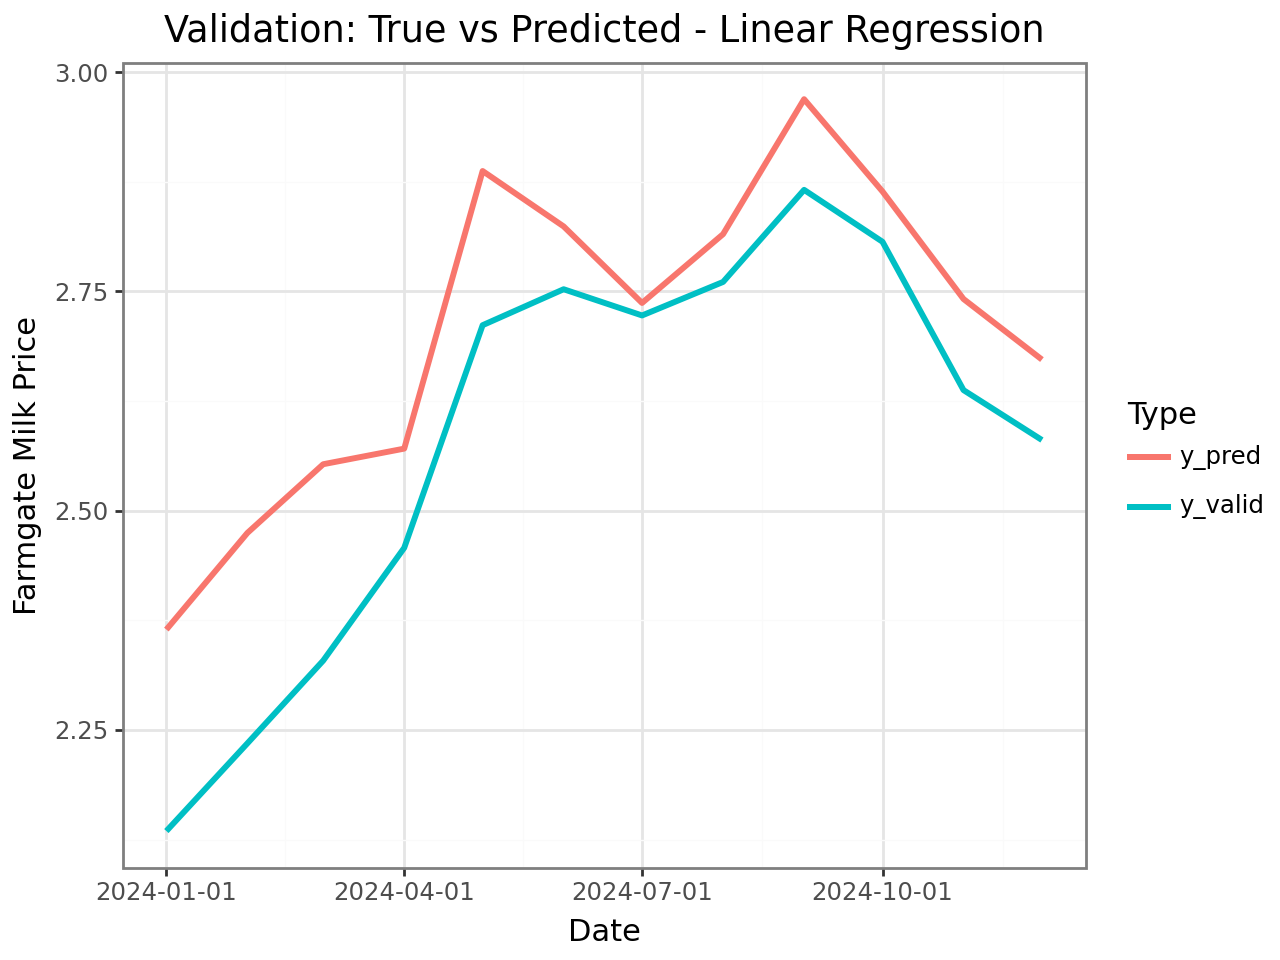

In [17]:
df_valid_preds_plot = df_valid_preds.copy() 

df_long = pd.melt(
    df_valid_preds_plot,
    id_vars=['date'],
    value_vars=['y_valid', 'y_pred'],
    var_name="Type",
    value_name="Value"
)

p = (
    ggplot(df_long, aes(x="date", y="Value", color="Type"))
    + geom_line(size=1.2)
    + theme_bw()
    + labs(x="Date", y="Farmgate Milk Price", title="Validation: True vs Predicted - Linear Regression")
)
set_option("figure_size", (12, 6))

p